## ResNet9

In [425]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Model definition
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        
        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        activations = {}  # Dictionary to store feature maps
        
        out = self.conv1(xb)
        activations['conv1'] = out
        out = self.conv2(out)
        activations['conv2'] = out
        out_res1 = self.res1(out) + out
        out = self.conv3(out_res1)
        activations['conv3'] = out
        out = self.conv4(out)
        activations['conv4'] = out
        out_res2 = self.res2(out) + out
        out = self.classifier(out_res2)
        # The classifier output is usually not stored as an activation map
        
        return out, activations
    
    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

# Data preprocessing
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Model, loss function, and optimizer
model = ResNet9(3, 10)
pretrained_path = '../models/cifar10/cifar_net.pth'
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')))

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [ ]:
correct = 0
total = 0
device = 'cpu'
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))  

In [426]:
import torch
import torchvision
import torchvision.transforms as transforms

# Ensure you have the testset loaded as before
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Identify indices of cat and dog images
airplane_indices = [i for i, (_, label) in enumerate(testset) if label == 0]
dog_indices = [i for i, (_, label) in enumerate(testset) if label == 5]

# Using these indices, extract the images and store them in tensor arrays
# Note: This approach loads all the selected images into memory, which may not be feasible with very large datasets

# Function to extract images by indices and stack them into a single tensor
def extract_images(dataset, indices):
    images = [dataset[i][0] for i in indices]  # dataset[i][0] gets the image tensor
    images_tensor = torch.stack(images)  # Stacks a list of tensors into a new tensor
    return images_tensor

# Extract and store cat and dog images
airplane_images = extract_images(testset, airplane_indices)
dog_images = extract_images(testset, dog_indices)

print(f'Airplane images tensor shape: {airplane_images.shape}')
print(f'Dog images tensor shape: {dog_images.shape}')


Files already downloaded and verified
Airplane images tensor shape: torch.Size([1000, 3, 32, 32])
Dog images tensor shape: torch.Size([1000, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


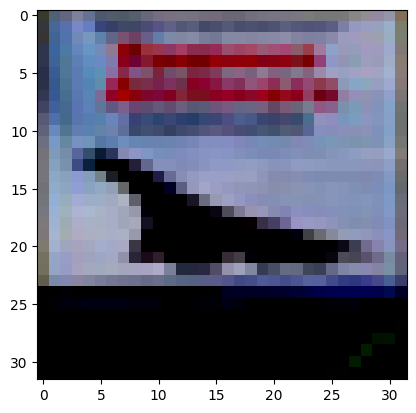

In [427]:
# Show an example cat image
import matplotlib.pyplot as plt

plt.imshow(airplane_images[0].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


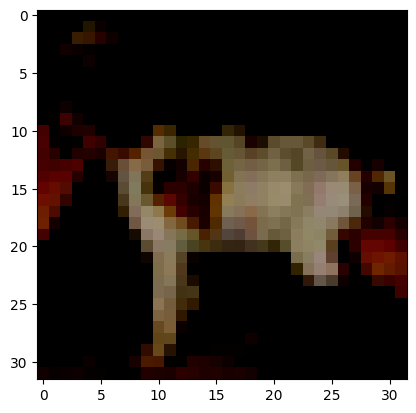

In [428]:
# Show an example dog image
plt.imshow(dog_images[0].permute(1, 2, 0));

In [429]:
# Test the model forward pass on a dog image
model.eval()
dog_output, dog_activations = model(dog_images[:250])

In [430]:
for k, v in dog_activations.items():
    print(f'{k:5s}: {v.shape}')

conv1: torch.Size([250, 64, 32, 32])
conv2: torch.Size([250, 128, 16, 16])
conv3: torch.Size([250, 256, 8, 8])
conv4: torch.Size([250, 512, 4, 4])


In [431]:
import einops

# For activation in activations dictionary, collapse last two dimensions
def collapse_activations(activations):
    for k, v in activations.items():
        activations[k] = einops.rearrange(v, 'b c h w -> b c (h w)')
    return activations

# Apply the function to the activations
dog_activations_collapsed = collapse_activations(dog_activations)

for k, v in dog_activations_collapsed.items():
    print(f'{k:5s}: {v.shape}')

conv1: torch.Size([250, 64, 1024])
conv2: torch.Size([250, 128, 256])
conv3: torch.Size([250, 256, 64])
conv4: torch.Size([250, 512, 16])


In [432]:
airplane_output, airplane_activations = model(airplane_images[:250])
airplane_activations_collapsed = collapse_activations(airplane_activations)

In [433]:
from sparse_autoencoder import SparseAutoencoder
import numpy as np

# Loss function is MSE (reconstruction loss) + L1 norm of the learned activations + similarity loss
def loss_fn(decoded_activations, learned_activations, resid_streams, lambda_=0.01):

    # RECONSTRUCTION LOSS
    recon_loss = F.mse_loss(decoded_activations, resid_streams)

    # SPARSITY LOSS
    learned_activations_flat = einops.rearrange(learned_activations, 'b s n -> (b s) n')
    sparsity_loss = torch.mean(torch.norm(learned_activations_flat, p=1, dim=1))

    # combine
    return recon_loss + (lambda_ * sparsity_loss) + recon_loss


def train(model, n_epochs, optimizer, train_streams, eval_streams, lambda_=0.01):
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        learned_activations, decoded_activations = model(train_streams)
        loss = loss_fn(decoded_activations, learned_activations, train_streams, lambda_=lambda_)
        loss.backward()
        optimizer.step()
        if epoch % (n_epochs // 10) == 0:
            model.eval()
            with torch.no_grad():
                eval_learned_activations, eval_decoded_activations = model(eval_streams)
                eval_loss = loss_fn(eval_decoded_activations, eval_learned_activations, eval_streams, lambda_=lambda_)
                print(f"Train loss = {loss.item():.4f}, Eval loss = {eval_loss.item():.4f}")
    return model

def get_resid_streams(pos_activations, neg_activations, layer_name: str):
    # Stack along first dimension
    pos_conv = pos_activations[layer_name]
    neg_conv = neg_activations[layer_name]
    resid_streams = torch.cat([pos_conv, neg_conv], dim=0)
    # Remove grad from resid_streams
    resid_streams = resid_streams.detach()
    return resid_streams

def get_indices(resid_streams):
    # Shuffle and create the labels
    device = 'cpu'
    labels = torch.ones(resid_streams.shape[0]//2) # BIG ASSUMPTION: assumes first half is positive and second half is negative
    labels = torch.cat((labels, torch.zeros_like(labels)))
    permutation = torch.randperm(resid_streams.shape[0])
    resid_shuffled = resid_streams[permutation, :, :]
    labels_shuffled = labels[permutation]
    cutoff = int(resid_shuffled.shape[0] * 0.8)
    train_streams = resid_shuffled[:cutoff, :, :].to(device)
    train_labels = labels_shuffled[:cutoff].to(device)
    eval_streams = resid_shuffled[cutoff:, :, :].to(device)
    eval_labels = labels_shuffled[cutoff:].to(device)

    n_epochs = 500
    num_unique = 100


    sae = SparseAutoencoder(n_input_features=resid_streams.shape[-1], n_learned_features=num_unique, geometric_median_dataset=None).to(device)

    optimizer = optim.Adam(sae.parameters(), lr=0.001)
    sae = train(sae, n_epochs, optimizer, train_streams, eval_streams, lambda_=0.02)
    sae = sae.to('cpu')
    resid_streams = resid_streams.to('cpu')

    learned_activations = sae(resid_streams)[0].detach().cpu().numpy()
    all_indices = np.argmax(learned_activations, axis=2)

    return sae, all_indices

def circuit_prediction_layer(all_indices, theta: float = 0.05):
    normalise = False

    # Negative and positive indices
    positive_indices = all_indices[:250, :]
    negative_indices = all_indices[250:, :]

    unique_to_positive_array = np.zeros(all_indices.shape[1])
    unique_to_negative_array = np.zeros(all_indices.shape[1])

    for i in range(all_indices.shape[1]):

        positive = set(positive_indices[:, i].tolist())
        negative = set(negative_indices[:, i].tolist())
        total_unique = positive.union(negative)

        # In positive but not negative
        unique_to_positive = list(positive - negative)
        # In negative but not positive
        unique_to_negative = list(negative - positive)

        if normalise:
            # Normalise by total number of unique indices
            unique_to_positive_array[i] = len(unique_to_positive) / len(total_unique)
            unique_to_negative_array[i] = len(unique_to_negative) / len(total_unique)
        
        else:
            # Set the values
            unique_to_positive_array[i] = len(unique_to_positive)
            unique_to_negative_array[i] = len(unique_to_negative)

    y_pred = unique_to_positive_array.flatten()

    # Normalise y_pred with softmax
    def softmax(x): return np.exp(x) / np.sum(np.exp(x), axis=0)

    y_pred = softmax(y_pred)

    # Get all channels exceeding the threshold theta
    selected_channels = np.where(y_pred > theta)[0]
    return selected_channels, y_pred
    

In [435]:
from tqdm import tqdm

# Now, we need to repeat for all layers
def circuit_prediction_model(pos_activations, neg_activations, theta: float = 0.05):
    circuit = {}
    for layer_name in tqdm(pos_activations.keys()):
        # Get the resid streams
        resid_streams = get_resid_streams(pos_activations, neg_activations, layer_name)
        # Get the indices
        sae, all_indices = get_indices(resid_streams)
        # Get the selected channels
        selected_channels, y_pred = circuit_prediction_layer(all_indices, theta=theta)
        circuit[layer_name] = {'sae': sae, 'selected_channels': selected_channels, 'y_pred': y_pred, 'all_indices': all_indices}

    return circuit

seed = 0
np.random.seed(seed)  # Set the seed for NumPy operations
torch.manual_seed(seed)  # Set the seed for CPU operations in PyTorch
circuit = circuit_prediction_model(dog_activations_collapsed, airplane_activations_collapsed, theta=0.05)

  0%|          | 0/4 [00:00<?, ?it/s]

Train loss = 2.2943, Eval loss = 1.5466
Train loss = 1.1985, Eval loss = 1.1812
Train loss = 1.1700, Eval loss = 1.1530
Train loss = 1.1251, Eval loss = 1.1078
Train loss = 1.0653, Eval loss = 1.0485
Train loss = 1.0159, Eval loss = 1.0002
Train loss = 0.9788, Eval loss = 0.9642
Train loss = 0.7361, Eval loss = 0.7274
Train loss = 0.7054, Eval loss = 0.6993
Train loss = 0.6960, Eval loss = 0.6903


 25%|██▌       | 1/4 [00:42<02:07, 42.53s/it]

Train loss = 2.4216, Eval loss = 2.0730
Train loss = 0.8856, Eval loss = 0.8703
Train loss = 0.7497, Eval loss = 0.7441
Train loss = 0.7120, Eval loss = 0.7079
Train loss = 0.6904, Eval loss = 0.6870
Train loss = 0.6751, Eval loss = 0.6723
Train loss = 0.6636, Eval loss = 0.6612
Train loss = 0.6547, Eval loss = 0.6526
Train loss = 0.6477, Eval loss = 0.6459
Train loss = 0.6422, Eval loss = 0.6406


 50%|█████     | 2/4 [01:09<01:06, 33.22s/it]

Train loss = 1.6406, Eval loss = 1.5380
Train loss = 0.6290, Eval loss = 0.6187
Train loss = 0.5142, Eval loss = 0.5077
Train loss = 0.4659, Eval loss = 0.4610
Train loss = 0.4424, Eval loss = 0.4382
Train loss = 0.4273, Eval loss = 0.4234
Train loss = 0.4146, Eval loss = 0.4108
Train loss = 0.4040, Eval loss = 0.4005
Train loss = 0.3953, Eval loss = 0.3920
Train loss = 0.3876, Eval loss = 0.3844


 75%|███████▌  | 3/4 [01:36<00:30, 30.28s/it]

Train loss = 4.1783, Eval loss = 4.0332
Train loss = 1.4174, Eval loss = 1.4332
Train loss = 0.9648, Eval loss = 0.9775
Train loss = 0.7359, Eval loss = 0.7469
Train loss = 0.6093, Eval loss = 0.6192
Train loss = 0.5314, Eval loss = 0.5405
Train loss = 0.4792, Eval loss = 0.4875
Train loss = 0.4418, Eval loss = 0.4497
Train loss = 0.4139, Eval loss = 0.4213
Train loss = 0.3922, Eval loss = 0.3994


100%|██████████| 4/4 [02:19<00:00, 34.81s/it]


In [630]:
for k, v in circuit.items():
    print(f'{k:5s}: {v["selected_channels"]}')

conv1: [23 63]
conv2: [ 8 51]
conv3: [ 53  71 163 227 240]
conv4: [61]


In [633]:
new_theta = 1e-4
for k, v in circuit.items():
    selected_channels, y_pred = circuit_prediction_layer(v['all_indices'], theta=new_theta)
    circuit[k]['selected_channels'] = selected_channels
    circuit[k]['y_pred'] = y_pred

In [634]:
for k, v in circuit.items():
    print(f'{k:5s}: {v["selected_channels"]}')

conv1: [14 18 22 23 24 30 43 44 46 48 56 63]
conv2: [  8  45  48  51  86 100 110 111]
conv3: [  4   6  10  23  29  35  39  40  43  46  49  52  53  62  69  70  71  74
  99 100 102 111 118 136 148 150 158 162 163 166 168 169 173 176 181 188
 209 227 240 245]
conv4: [ 25  61  91 116 126 156 168 178 199 225 291 298 401 428]


In [635]:
keep_channels = {
    k: list(v['selected_channels']) for k, v in circuit.items()
}

### Linear probe

In [459]:
# keep_channels_corrupted is a dictionary with the same structure as keep_channels, but with different channel indices
# The indices are corrupted by adding 1 to each index
keep_channels_corrupted = {k: [i-1 for i in v] for k, v in keep_channels.items()}

In [460]:
# Get all the dog actvations from the circuit
def get_selected_activations(activations, keep_channels):
    selected_activations = {}
    for k, v in keep_channels.items():
        selected_activations[k] = activations[k][:, v, :].detach().cpu()
    return selected_activations

dog_selected_activations = get_selected_activations(dog_activations_collapsed, keep_channels)
airplane_selected_activations = get_selected_activations(airplane_activations_collapsed, keep_channels)

dog_selected_activations_corrupted = get_selected_activations(dog_activations_collapsed, keep_channels_corrupted)
airplane_selected_activations_corrupted = get_selected_activations(airplane_activations_collapsed, keep_channels_corrupted)

In [483]:
import torch
from sklearn.model_selection import train_test_split
from einops import rearrange

def train_linear_probe(activations, labels, n_epochs=25, eval_size=0.1, sparsity_penalty=0.0):
    # Split the data into training and evaluation sets
    X_train, X_eval, y_train, y_eval = train_test_split(activations, labels, test_size=eval_size, random_state=42)
    
    # Get the number of classes
    n_classes = len(torch.unique(labels))
    
    # Get the shape of the activations
    batch_size, height, width = X_train.shape
    
    # Define the linear probe with an extra dimension
    linear_probe = nn.Linear(height * width, n_classes)
    
    # Define the optimizer
    optimizer = optim.Adam(linear_probe.parameters(), lr=0.001)
    
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Train the probe
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Rearrange the activations to (batch_size, height * width)
        X_train_rearranged = rearrange(X_train, 'b h w -> b (h w)')
        output = linear_probe(X_train_rearranged)

        # Calculate the sparsity penalty
        sparsity_loss = sparsity_penalty * torch.norm(linear_probe.weight, p=1)
        
        # Add the sparsity penalty to the loss
        loss = loss_fn(output, y_train.long()) + sparsity_loss
        
        #loss = loss_fn(output, y_train.long())
        loss.backward()
        optimizer.step()
        
        if epoch % (n_epochs // 10) == 0 or epoch == n_epochs - 1:
            with torch.no_grad():
                # Rearrange the evaluation activations to (batch_size, height * width)
                X_eval_rearranged = rearrange(X_eval, 'b h w -> b (h w)')
                eval_output = linear_probe(X_eval_rearranged)
                
                _, predicted = torch.max(eval_output, 1)
                eval_accuracy = (predicted == y_eval).float().mean()
                
                eval_loss = loss_fn(eval_output, y_eval.long())
                
                if epoch == n_epochs - 1:
                    print(f'Final Eval Loss: {eval_loss.item():.4f}, Eval Accuracy: {eval_accuracy.item():.4f}')
                else:
                    print(f'Epoch {epoch}, Loss {loss.item():.4f}, Eval Accuracy {eval_accuracy.item():.4f}')
    
    return linear_probe, eval_accuracy.item()

def linear_probe_pipeline(dog_activations, airplane_activations, layer, random_seed):
    torch.manual_seed(random_seed)
    # Get the labels for the dog and airplane images
    labels = torch.ones(dog_activations[layer].shape[0])
    labels = torch.cat((labels, torch.zeros_like(labels)))
    
    # Concatenate the activations along dimension 0
    activations = torch.cat((dog_activations[layer], airplane_activations[layer]), dim=0)
    
    # Shuffle the activations and labels
    permutation = torch.randperm(activations.shape[0])
    activations_shuffled = activations[permutation]
    labels_shuffled = labels[permutation]
    
    # Train the linear probe
    linear_probe, eval_accuracy = train_linear_probe(activations_shuffled, labels_shuffled, n_epochs=50)
    return linear_probe, eval_accuracy

results = {}
num_runs = 5

for layer in ['conv1', 'conv2', 'conv3', 'conv4']:
    print(f'Layer: {layer}')
    print('-' * 20)
    results[layer] = {}
    
    # Do it for the normal activations
    print('Normal activations')
    eval_accuracies = []
    for i in range(num_runs):
        _, eval_accuracy = linear_probe_pipeline(dog_selected_activations, airplane_selected_activations, layer, random_seed=i)
        eval_accuracies.append(eval_accuracy)
    results[layer]['normal'] = np.mean(eval_accuracies)
    results[layer]['normal_std'] = np.std(eval_accuracies)
    
    # Do it for the corrupted activations
    print('Corrupted activations')
    eval_accuracies_corrupted = []
    for i in range(num_runs):
        _, eval_accuracy_corrupted = linear_probe_pipeline(dog_selected_activations_corrupted, airplane_selected_activations_corrupted, layer, random_seed=i)
        eval_accuracies_corrupted.append(eval_accuracy_corrupted)
    results[layer]['corrupted'] = np.mean(eval_accuracies_corrupted)
    results[layer]['corrupted_std'] = np.std(eval_accuracies_corrupted)
    
    print()

print('Final Evaluation Accuracies:')
print(results)

Layer: conv1
--------------------
Normal activations
Epoch 0, Loss 0.6929, Eval Accuracy 0.6400
Epoch 5, Loss 0.4546, Eval Accuracy 0.8200
Epoch 10, Loss 0.3565, Eval Accuracy 0.8800
Epoch 15, Loss 0.3000, Eval Accuracy 0.8400
Epoch 20, Loss 0.2582, Eval Accuracy 0.8400
Epoch 25, Loss 0.2241, Eval Accuracy 0.8400
Epoch 30, Loss 0.1959, Eval Accuracy 0.8600
Epoch 35, Loss 0.1731, Eval Accuracy 0.8400
Epoch 40, Loss 0.1546, Eval Accuracy 0.8400
Epoch 45, Loss 0.1394, Eval Accuracy 0.8400
Final Eval Loss: 0.3925, Eval Accuracy: 0.8600
Epoch 0, Loss 0.7607, Eval Accuracy 0.5400
Epoch 5, Loss 0.4843, Eval Accuracy 0.8800
Epoch 10, Loss 0.3794, Eval Accuracy 0.8600
Epoch 15, Loss 0.3243, Eval Accuracy 0.8600
Epoch 20, Loss 0.2804, Eval Accuracy 0.8800
Epoch 25, Loss 0.2451, Eval Accuracy 0.8600
Epoch 30, Loss 0.2175, Eval Accuracy 0.8600
Epoch 35, Loss 0.1940, Eval Accuracy 0.8600
Epoch 40, Loss 0.1742, Eval Accuracy 0.8600
Epoch 45, Loss 0.1578, Eval Accuracy 0.8600
Final Eval Loss: 0.2936,

In [484]:
import plotly.graph_objects as go

# Extract the layers and evaluation accuracies from the results dictionary
layers = list(results.keys())
normal_accuracies = [results[layer]['normal'] for layer in layers]
normal_stds = [results[layer]['normal_std'] for layer in layers]
corrupted_accuracies = [results[layer]['corrupted'] for layer in layers]
corrupted_stds = [results[layer]['corrupted_std'] for layer in layers]

# Create the trace for normal activations
trace_normal = go.Scatter(
    x=layers,
    y=normal_accuracies,
    mode='lines+markers',
    name='Our channels',
    line=dict(color='blue', width=4),
    marker=dict(size=8, symbol='circle', color='blue'),
    error_y=dict(
        type='data',
        array=normal_stds,
        visible=True
    )
)

# Create the trace for corrupted activations
trace_corrupted = go.Scatter(
    x=layers,
    y=corrupted_accuracies,
    mode='lines+markers',
    name='Random channels',
    line=dict(color='red', width=4),
    marker=dict(size=8, symbol='square', color='red'),
    error_y=dict(
        type='data',
        array=corrupted_stds,
        visible=True
    )
)

# Create the layout for the plot
layout = go.Layout(
    xaxis=dict(title='Layer'),
    yaxis=dict(title='Evaluation Accuracy'),
    font=dict(family='Palatino', size=24),
    legend=dict(x=0.8, y=0.99),
    plot_bgcolor='white',
    width=800,
    height=500,
)

# Create the figure and add the traces and layout
fig = go.Figure(data=[trace_normal, trace_corrupted], layout=layout)

# Save the figure as a pdf
fig.write_image('../output/figures/linear_probe_cnn_accuracy.pdf')

# Display the plot
fig.show()

### Max activating images in dataset

In [528]:
def compute_activations(model, dataloader, layer_name):
    model.eval()
    activations = []
    images = []
    
    with torch.no_grad():
        for data, _ in dataloader:
            _, act = model(data)
            activations.append(act[layer_name])
            images.append(data)
    
    activations = torch.cat(activations)
    images = torch.cat(images)
    
    return activations, images

def get_top_k_activations(activations, images, channel_idx, k=5):
    # Compute the mean activation across the spatial dimensions (8x8)
    activations = activations.mean(dim=(2, 3))
    
    # Select the activations of the specified channel
    activations = activations[:, channel_idx]
    
    _, top_k_max_indices = torch.topk(activations, k, dim=0)
    _, top_k_min_indices = torch.topk(activations, k, dim=0, largest=False)
    
    top_k_max_images = images[top_k_max_indices]
    top_k_min_images = images[top_k_min_indices]
    return top_k_max_images, top_k_min_images


# Example usage
layer_name = 'conv4'
channel_idx = 61
k = 5

activations, images = compute_activations(model, testloader, layer_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

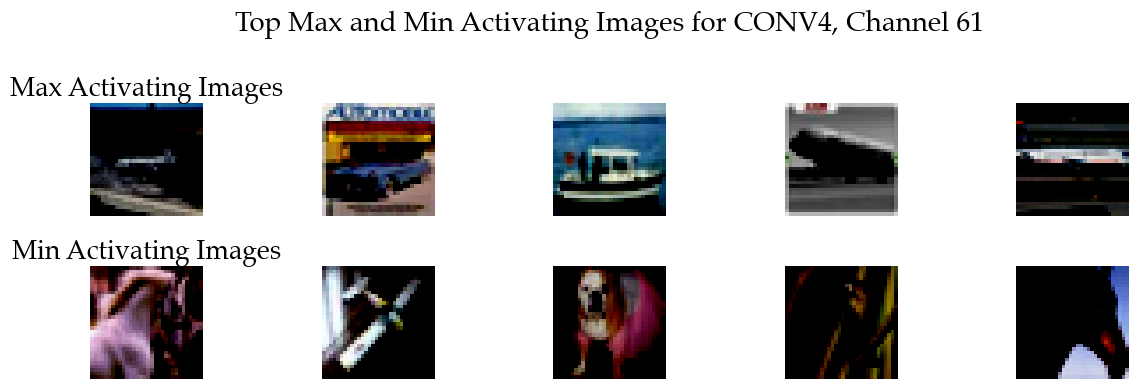

In [529]:
top_k_max_images, top_k_min_images = get_top_k_activations(activations, images, channel_idx, k)

# Visualize the top k max and min activating images
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set Matplotlib to use Palatino font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Palatino'
rcParams['font.size'] = 16  # You can adjust the size to better fit your publication standards

fig, axes = plt.subplots(2, k, figsize=(12, 4))
for i in range(k):
    # Adjust the image if needed, here assuming the images are in a PyTorch tensor format
    axes[0, i].imshow(top_k_max_images[i].permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(top_k_min_images[i].permute(1, 2, 0))
    axes[1, i].axis('off')

# Set titles for the rows
axes[0, 0].set_title(f'Max Activating Images')
axes[1, 0].set_title(f'Min Activating Images')

# Set title
plt.suptitle(f'Top Max and Min Activating Images for {layer_name.upper()}, Channel {channel_idx}', fontsize=20)

# Layout adjustments for publication quality
plt.tight_layout(pad=1.0)  # Increase padding to ensure titles and images don't overlap
# Save figure as PDF
plt.savefig(f'../output/figures/top_max_min_activating_images_{layer}_{channel_idx}.pdf', format='pdf')
plt.show()

### Can we use our circuit to increase the probability of dog?

In [533]:
# Model definition
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        
        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        activations = {}  # Dictionary to store feature maps
        
        out = self.conv1(xb)
        activations['conv1'] = out
        out = self.conv2(out)
        activations['conv2'] = out
        out_res1 = self.res1(out) + out
        out = self.conv3(out_res1)
        activations['conv3'] = out
        out = self.conv4(out)
        activations['conv4'] = out
        out_res2 = self.res2(out) + out
        out = self.classifier(out_res2)
        # The classifier output is usually not stored as an activation map
        
        return out, activations
    
    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

# Model, loss function, and optimizer
model = ResNet9(3, 10)
pretrained_path = '../models/cifar10/cifar_net.pth'
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [578]:
import torch
import torchvision
import torchvision.transforms as transforms
import random

def causal_intervention(model, dog_image, non_dog_image, layers_channels):
    model.eval()
    with torch.no_grad():
        # Get activations for both images
        _, dog_activations = model(dog_image.unsqueeze(0))
        _, non_dog_activations = model(non_dog_image.unsqueeze(0))

        # # Modify the non-dog activations based on the specified channels in each layer
        # for layer, channels in layers_channels.items():
        #     non_dog_activations[layer][:, channels, :, :] = dog_activations[layer][:, channels, :, :]

        # Run the forward pass with modified activations using a custom forward method
        modified_output = forward_with_custom_activations(model, dog_activations, non_dog_image.unsqueeze(0), layers_channels)
        modified_prob = torch.softmax(modified_output, dim=-1)[0, 5]  # Assuming class 5 is "dog"

    # Original classification for non-dog image
    original_output, _ = model(non_dog_image.unsqueeze(0))
    original_prob = torch.softmax(original_output, dim=-1)[0, 5]

    return original_prob.item(), modified_prob.item(), original_output.squeeze(), modified_output.squeeze()

def forward_with_custom_activations(model, dog_activations, img, layers_channels):
    # This function runs a forward pass using the modified activation maps
    x = model.conv1(img)
    # Modify the activations for the specified channels in the first layer
    for channel in layers_channels['conv1']:
        x[:, channel, :, :] = dog_activations['conv1'][:, channel, :, :]
    x = model.conv2(x)
    # Modify the activations for the specified channels in the second layer
    for channel in layers_channels['conv2']:
        x[:, channel, :, :] = dog_activations['conv2'][:, channel, :, :]
    x_res1 = model.res1(x) + x
    x = model.conv3(x_res1)
    # Modify the activations for the specified channels in the third layer
    for channel in layers_channels['conv3']:
        x[:, channel, :, :] = dog_activations['conv3'][:, channel, :, :]
    x = model.conv4(x)
    # Modify the activations for the specified channels in the fourth layer
    for channel in layers_channels['conv4']:
        x[:, channel, :, :] = dog_activations['conv4'][:, channel, :, :]
    x_res2 = model.res2(x) + x
    x = model.classifier(x_res2)
    return x
    

# Ensure you have the testset loaded as before
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Identify indices of airplane and dog images
airplane_indices = [i for i, (_, label) in enumerate(testset) if label == 0]
dog_indices = [i for i, (_, label) in enumerate(testset) if label == 5]

# Function to extract images by indices and stack them into a single tensor
def extract_images(dataset, indices):
    images = [dataset[i][0] for i in indices]  # dataset[i][0] gets the image tensor
    images_tensor = torch.stack(images)  # Stacks a list of tensors into a new tensor
    return images_tensor

# Extract and store airplane and dog images
airplane_images = extract_images(testset, airplane_indices)
dog_images = extract_images(testset, dog_indices)

Files already downloaded and verified


In [579]:
# Randomly select a dog image and a non-dog (airplane) image
dog_image = dog_images[random.randint(0, len(dog_images) - 1)]
non_dog_image = airplane_images[random.randint(0, len(airplane_images) - 1)]

# Define the layers and channels for intervention
layers_channels = {
    'conv1': [23, 63],
    'conv2': [8, 51],
    'conv3': [53, 71, 163, 227, 240],
    'conv4': [61]
}

# Assuming you have a trained ResNet model (model)
original_prob, modified_prob, original_output, modified_output = causal_intervention(model, dog_image, non_dog_image, layers_channels)

print(f"Original probability of dog: {original_prob:.4f}")
print(f"Modified probability of dog: {modified_prob:.4f}")
print(f"Original output logit for dog: {original_output[5]}")
print(f"Modified output logit for dog: {modified_output[5]}")

Original probability of dog: 0.0000
Modified probability of dog: 0.0000
Original output logit for dog: -9.668745040893555
Modified output logit for dog: -8.825575828552246


In [585]:
# Extract and store airplane and dog images
airplane_images = extract_images(testset, airplane_indices)
dog_images = extract_images(testset, dog_indices)

# Randomly select a dog image and a non-dog (airplane) image
dog_image = dog_images[random.randint(0, len(dog_images) - 1)]
non_dog_image = airplane_images[random.randint(0, len(airplane_images) - 1)]

# Define the layers and channels for intervention
layers_channels_corrupted = {
    'conv1': [0, 1],
    'conv2': [0, 1],
    'conv3': [0, 1, 2, 3, 4],
    'conv4': [0]
}

# Assuming you have a trained ResNet model (model)
original_prob, modified_prob, original_output, modified_output = causal_intervention(model, dog_image, non_dog_image, layers_channels_corrupted)

print(f"Original probability of dog: {original_prob:.4f}")
print(f"Modified probability of dog: {modified_prob:.4f}")
print(f"Original output logit for dog: {original_output[5]}")
print(f"Modified output logit for dog: {modified_output[5]}")

Original probability of dog: 0.0000
Modified probability of dog: 0.0000
Original output logit for dog: -15.896688461303711
Modified output logit for dog: -14.704957008361816


In [ ]:
# Turn grad off for torch
torch.set_grad_enabled(False)

In [616]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
from tqdm import tqdm

# Assuming the functions and model setup you provided are defined elsewhere in the script

def compute_logit_changes(model, testset, layers_channels, num_pairs=100):
    dog_indices = [i for i, (_, label) in enumerate(testset) if label == 5]  # Class label for dog
    non_dog_indices = [i for i, (_, label) in enumerate(testset) if label != 5]  # Non-dog classes

    # Storage for logit changes
    changes = []

    for _ in tqdm(range(num_pairs)):
        # Randomly select a dog image and a non-dog image
        dog_image = testset[random.choice(dog_indices)][0]
        non_dog_image = testset[random.choice(non_dog_indices)][0]

        # Perform the causal intervention
        original_prob, modified_prob, original_output, modified_output = causal_intervention(model, dog_image, non_dog_image, layers_channels)

        # Calculate the change in logit for the dog class
        logit_change = modified_output[5].item() - original_output[5].item()
        changes.append(logit_change)

    # Compute the mean change in logits
    mean_change = sum(changes) / len(changes)
    return mean_change

# Define the layers and channels for both scenarios
layers_channels_specified = {
    'conv1': [23],
    'conv2': [8], #[8],
    'conv3': [], #[53],
    'conv4': [], #[61]
}

# Corrupted is randomly selected channels in each layer
layers_channels_corrupted = {
    # Conv1 has 64 channels
    'conv1': [random.randint(0, 63)],
    'conv2': [random.randint(0, 63)], #[random.randint(0, 127)],
    'conv3': [], #[random.randint(0, 255)],
    'conv4': [], #[random.randint(0, 511)]
}

# Load the CIFAR10 test dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [617]:
# Calculate mean changes for specified and corrupted channels
mean_change_specified = compute_logit_changes(model, testset, layers_channels_specified)
mean_change_corrupted = compute_logit_changes(model, testset, layers_channels_corrupted)

print(f"Mean logit increase using specified channels: {mean_change_specified:.4f}")
print(f"Mean logit increase using random channels: {mean_change_corrupted:.4f}")

100%|██████████| 100/100 [00:02<00:00, 34.20it/s]

Mean logit increase using specified channels: 0.0034
Mean logit increase using random channels: 0.6306


In [639]:
def logit_change_per_channel(model, testset, layer, num_pairs=100):
    dog_indices = [i for i, (_, label) in enumerate(testset) if label == 5]  # Class label for dog
    non_dog_indices = [i for i, (_, label) in enumerate(testset) if label != 5]  # Non-dog classes

    # Number of channels in the first convolution layer of ResNet9
    num_channels = model.conv1[0].out_channels
    logit_changes = {channel: [] for channel in range(num_channels)}

    for _ in tqdm(range(num_pairs)):
        # Randomly select a dog image and a non-dog image
        dog_image = testset[random.choice(dog_indices)][0]
        non_dog_image = testset[random.choice(non_dog_indices)][0]

        # Get original logits without intervention
        original_output, _ = model(non_dog_image.unsqueeze(0))
        original_output = original_output.squeeze()

        for channel in range(num_channels):
            # Modify one channel at a time
            layers_channels = {'conv1': [], layer: [channel], 'conv3': [], 'conv4': []}
            _, _, _, modified_output = causal_intervention(model, dog_image, non_dog_image, layers_channels)
            modified_output = modified_output.squeeze()
            
            # Calculate the change in logit for the dog class
            logit_change = modified_output[5].item() - original_output[5].item()
            logit_changes[channel].append(logit_change)

    # Compute the mean change in logits for each channel
    mean_logit_changes = {channel: sum(changes) / len(changes) for channel, changes in logit_changes.items()}
    return mean_logit_changes

# Load the CIFAR10 test dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Assuming you have a trained ResNet model (model)
average_logit_changes_conv1 = logit_change_per_channel(model, testset, 'conv2')

# Print the results
print("Average logit increases per channel in conv1:")
for channel, avg_change in average_logit_changes_conv1.items():
    print(f"Channel {channel}: {avg_change:.4f}")

Files already downloaded and verified


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]

Average logit increases per channel in conv1:
Channel 0: -0.0424
Channel 1: 0.1007
Channel 2: 0.0966
Channel 3: 0.0147
Channel 4: 0.0525
Channel 5: -0.0030
Channel 6: 0.1058
Channel 7: 0.0171
Channel 8: 0.0179
Channel 9: -0.0409
Channel 10: -0.0314
Channel 11: -0.1448
Channel 12: -0.0500
Channel 13: 0.0720
Channel 14: 0.0101
Channel 15: 0.0461
Channel 16: 0.0948
Channel 17: 0.0459
Channel 18: -0.0114
Channel 19: 0.1638
Channel 20: 0.1075
Channel 21: 0.0266
Channel 22: 0.0768
Channel 23: 0.0405
Channel 24: 0.0350
Channel 25: 0.0906
Channel 26: 0.0528
Channel 27: 0.1151
Channel 28: -0.0127
Channel 29: -0.0208
Channel 30: 0.0757
Channel 31: 0.0098
Channel 32: -0.0733
Channel 33: -0.0144
Channel 34: 0.3073
Channel 35: 0.0329
Channel 36: 0.0456
Channel 37: -0.0393
Channel 38: 0.0211
Channel 39: 0.0875
Channel 40: 0.3718
Channel 41: 0.0698
Channel 42: 0.0202
Channel 43: 0.0252
Channel 44: -0.0631
Channel 45: 0.0245
Channel 46: 0.1396
Channel 47: 0.0212
Channel 48: 0.0135
Channel 49: -0.0069


In [640]:
import plotly.graph_objects as go

# layers_channels = {
#     # 'conv1': [23, 53],
#     # 'conv2': [8, 51],
#     # 'conv3': [53, 71, 163, 227, 240],
#     # 'conv4': [61]
# }

layers_channels = {'conv1': [14, 18, 22, 23, 24, 30, 43, 44, 46, 48, 56, 63], 'conv2': [8, 45, 48, 51, 86, 100, 110, 111], 'conv3': [4, 6, 10, 23, 29, 35, 39, 40, 43, 46, 49, 52, 53, 62, 69, 70, 71, 74, 99, 100, 102, 111, 118, 136, 148, 150, 158, 162, 163, 166, 168, 169, 173, 176, 181, 188, 209, 227, 240, 245], 'conv4': [25, 61, 91, 116, 126, 156, 168, 178, 199, 225, 291, 298, 401, 428]}

layer = 'conv2'

# Extract the channels and average logit changes
channels = list(average_logit_changes_conv1.keys())
logit_changes = list(average_logit_changes_conv1.values())

# Determine colors for the bars based on whether the channel is in the specified list
colors = ['red' if channel in layers_channels[layer] else 'blue' for channel in channels]

# Create the bar plot
fig = go.Figure(data=[go.Bar(x=channels, y=logit_changes, marker_color=colors)])

# Update the layout
fig.update_layout(
    title=f'Average Logit Increases per Channel in {layer}',
    xaxis_title='Channel',
    yaxis_title='Average Logit Increase',
    font=dict(family='Palatino', size=18),
    width=800,
    height=500
)

# Display the plot
fig.show()

### Training the head of the classifier

In [ ]:
# Override the forward method to modify the activations
def modified_forward(self, xb):
    activations = {}
    out = self.conv1(xb)
    out = self.zero_out_channels(out, 'conv1')
    activations['conv1'] = out

    out = self.conv2(out)
    out = self.zero_out_channels(out, 'conv2')
    activations['conv2'] = out

    out_res1 = self.res1(out) + out
    out = self.conv3(out_res1)
    out = self.zero_out_channels(out, 'conv3')
    activations['conv3'] = out

    out = self.conv4(out)
    out = self.zero_out_channels(out, 'conv4')
    activations['conv4'] = out

    out_res2 = self.res2(out) + out
    out = self.classifier(out_res2)
    return out, activations

def zero_out_channels(self, x, layer_name):
    if layer_name in keep_channels:
        indices = keep_channels[layer_name]
        mask = torch.zeros_like(x)
        mask[:, indices, :, :] = 1
        x = x * mask
    else:
        x.zero_()
    return x

# Assign the modified forward method to the model
model.modified_forward = modified_forward.__get__(model)
model.zero_out_channels = zero_out_channels.__get__(model)

In [ ]:
# Set what accuracy we get with normal model
model.eval()
device = 'cpu'
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        labels = (labels == 5).long()
        
        outputs, _ = model.modified_forward(images)
        print(outputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# What happens if we keep random channels?
keep_channels = {'conv1': [1],
 'conv2': [1, 2],
 'conv3': [1, 2],
 'conv4': [1, 2, 3, 4]}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# Make a copy of the pretrained ResNet model
model_copy = ResNet9(3, 10)
model_copy.load_state_dict(model.state_dict())
model_copy.modified_forward = modified_forward.__get__(model_copy)
model_copy.zero_out_channels = zero_out_channels.__get__(model_copy)

# Remove the existing classifier head
num_features = model_copy.classifier[-1].in_features
model_copy.classifier = nn.Identity()

# Create a new classifier head with 2 output features
new_classifier = nn.Sequential(
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(num_features, 2)
)
model_copy.classifier = new_classifier

# Freeze all the weights except for the new classifier head
for param in model_copy.parameters():
    param.requires_grad = False
for param in model_copy.classifier.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_copy.classifier.parameters(), lr=0.05)

# Create subsets of the train and test datasets containing only dog and airplane images
train_indices = airplane_indices + dog_indices
test_indices = [i for i, (_, label) in enumerate(testset) if label in [0, 5]]

train_subset = Subset(trainset, train_indices)
test_subset = Subset(testset, test_indices)

# Create data loaders for the subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_copy.to(device)

for epoch in range(num_epochs):
    model_copy.train()
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images = images.to(device)
        labels = labels.to(device)
        
        # Convert labels to binary (0 for "airplane", 1 for "dog")
        labels = (labels == 5).long()
        
        optimizer.zero_grad()
        outputs, _ = model_copy.modified_forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print the loss after every mini-batch
        #print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    model_copy.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            labels = (labels == 5).long()
            
            outputs, _ = model_copy.modified_forward(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}")

In [ ]:
# Model definition
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        
        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out_res1 = self.res1(out) + out
        out = self.conv3(out_res1)
        out = self.conv4(out)
        out_res2 = self.res2(out) + out
        out = self.classifier(out_res2)
        # The classifier output is usually not stored as an activation map
        
        return out
    
    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

# Model, loss function, and optimizer
model = ResNet9(3, 10)
pretrained_path = '../models/cifar10/cifar_net.pth'
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')))

In [ ]:
# Test model by passing a dog image through
model.eval()
dog_output = model(dog_images[:250])

In [ ]:
from lucent.optvis import render, param, transform, objectives


device = 'cpu'
model.to(device).eval()

_ = render.render_vis(model, "conv4:61")

In [ ]:
# The default is optimizing for a channel/filter
obj = objectives.channel("conv1", 39)
_ = render.render_vis(model, obj, show_inline=True)

In [ ]:
# The default is optimizing for a channel/filter
obj = objectives.channel("conv1", 37)
_ = render.render_vis(model, obj, show_inline=True)

In [ ]:
# The default is optimizing for a channel/filter
obj = objectives.channel("conv1", 23)
images = render.render_vis(model, obj, show_inline=True)

# Show the image
plt.imshow(images[0].squeeze())

In [ ]:
# Just like in Lucid, we can sum objectives
# Here we sum the previous two objectives and get a mix of the two images
channel = lambda n: objectives.channel("conv2", n)
obj = channel(8) + channel(86)# + channel(39) #+channel(346) + channel(489)
images = render.render_vis(model, obj, show_inline=True, transforms=[])

In [ ]:
# A visualization with CPPN parameterization

cppn_param_f = lambda: param.cppn(128)
# We initialize an optimizer with lower learning rate for CPPN
cppn_opt = lambda params: torch.optim.Adam(params, 3e-3)
images = render.render_vis(model, obj, cppn_param_f, cppn_opt, transforms=[], show_inline=True)

# Show the image
plt.imshow(images[0].squeeze());

In [ ]:
# Just like in Lucid, we can sum objectives
# Here we sum the previous two objectives and get a mix of the two images
channel = lambda n: objectives.channel("conv4", n)
obj = channel(61)# + channel(116) #+channel(346) + channel(489)
images = render.render_vis(model, obj, show_inline=True)

In [ ]:
# A visualization with CPPN parameterization

cppn_param_f = lambda: param.cppn(128)
# We initialize an optimizer with lower learning rate for CPPN
cppn_opt = lambda params: torch.optim.Adam(params, 2e-3)
images = render.render_vis(model, obj, cppn_param_f, cppn_opt, transforms=[], show_inline=True)

# Show the image
plt.imshow(images[0].squeeze())

In [ ]:
all_transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(list(range(-10,10)) + list(range(-5,5)) + 10*list(range(-2,2))),
    transform.jitter(2),
]

images = render.render_vis(model, obj, transforms=all_transforms, show_inline=True)

# Show the image
plt.imshow(images[0].squeeze())

In [ ]:
# Adding a suite of transforms with CPPN

images = render.render_vis(model, obj, cppn_param_f, cppn_opt, transforms=all_transforms, show_inline=True)

# Show the image
plt.imshow(images[0].squeeze())

In [ ]:
# images[0] is shape 1x128x128x3
import matplotlib.pyplot as plt

# Reshape and show image
plt.imshow(images[0].squeeze());

In [ ]:
# A visualization with gradient descent in Fourier basis
from lucent.optvis import render, param, transform, objectives

obj = channel(61) + channel(116) #+channel(346) + channel(489)
param_f = lambda: param.image(128, fft=True, decorrelate=False)
images = render.render_vis(model, obj, param_f, transforms=[])

plt.imshow(images[0].squeeze());

In [ ]:
# A visualization with gradient descent in Fourier basis + channel decorrelation
# This is the default parameterization without transforms (see below)

param_f = lambda: param.image(128, fft=True, decorrelate=True)
_ = render.render_vis(model, obj, param_f, transforms=[], show_inline=True)

In [ ]:
# Plotly imshow y_pred
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=y_pred.reshape(1, -1), colorscale='RdBu', zmin=0, zmax=1))
fig.show()

In [ ]:
# Index 37 looks important
index = 23

average_doc_activation = dog_conv1.mean(dim=0)[index, :].reshape(32, 32).detach()
average_airplane_activation = airplane_conv1.mean(dim=0)[index, :].reshape(32, 32).detach()

# Show the two side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(average_doc_activation, cmap='viridis')
ax[0].set_title('Average dog activation')
ax[1].imshow(average_airplane_activation, cmap='viridis')
ax[1].set_title('Average airplane activation')
plt.show()

In [ ]:
# Look at it on one specific example
example_index = np.random.randint(0, 250)
dog_example = dog_conv1[example_index, index, :].reshape(32, 32).detach()
airplane_example = airplane_conv1[example_index, index, :].reshape(32, 32).detach()

# Show the two side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(dog_example, cmap='viridis')
ax[0].set_title('Dog activation')
ax[1].imshow(airplane_example, cmap='viridis')
ax[1].set_title('Airplane activation')
plt.show()